#  <font color='red'> Bayesian Classification </font> 

We obtain the probability distribution of the line parameters rather than scalar estimates of slope and y intercept.
 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
import scipy as sc
from scipy.stats import multivariate_normal
import pandas as pd

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [8, 4]


## Reading the data

Change fname to appropriate path

In [5]:
fname = 'fishes.csv'
data = pd.read_csv(fname)
data.head(10)

,Fishtype,lightness,length
0,1.0,2.220252,-1.603168
1,1.0,3.771725,-3.621082
2,1.0,2.898739,-3.625635
3,1.0,4.484533,-1.227532
4,1.0,1.005928,-3.027846
5,0.0,-0.611962,0.252595
6,0.0,-1.617321,-0.085127
7,0.0,-1.086477,0.932646
8,1.0,2.255999,-2.207233
9,1.0,4.633921,-3.386524


## Extracting the different features

In [6]:
# Extracting the fields with Fishtype=1 (bass)
bass = data[data["Fishtype"] == 1]
basslightness = bass['lightness'].to_numpy()
basslength = bass['length'].to_numpy()
basscount = bass['lightness'].count()

# Extracting the fields with Fishtype=0 (salmon)
salmon = data[data["Fishtype"] == 0]
salmonlightness = salmon['lightness'].to_numpy()
salmonlength = salmon['length'].to_numpy()
salmoncount = salmon['lightness'].count()

print(basscount)
print(salmoncount)

32304
18203


## Plotting the histogram

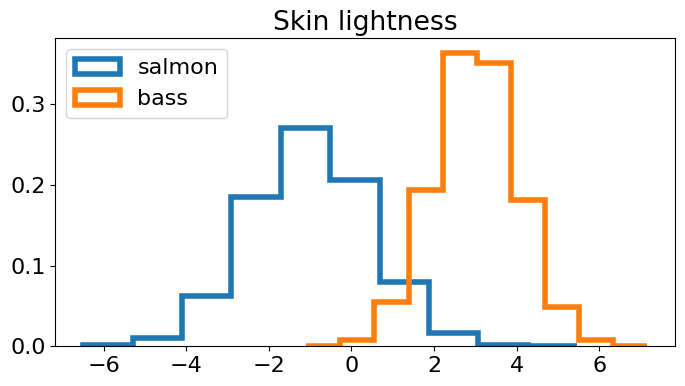

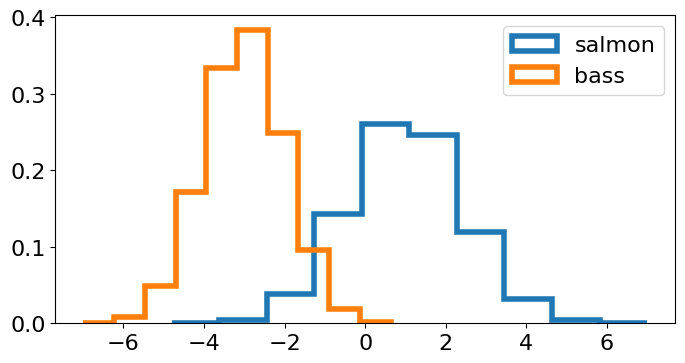

In [7]:
fig = plt.figure()
pt = plt.hist(salmonlightness,label='salmon',histtype='step',linewidth=4,density=True)
pt = plt.hist(basslightness,label='bass',histtype='step',linewidth=4,density=True)
s = fig.gca().legend()
s= plt.title('Skin lightness')


fig = plt.figure()
pt = plt.hist(salmonlength,label='salmon',histtype='step',linewidth=4,density=True)
pt = plt.hist(basslength,label='bass',histtype='step',linewidth=4,density=True)
s = fig.gca().legend()


## Estimation of the probability densities

We will rely on histograms to estimate the conditional probability densities $p({\rm lightness}|{\rm bass})$, $p({\rm lightness}|{\rm salmon})$

The prior probabilities $p({\rm salmon})$ from the training data as 

$$p({\rm salmon}) = \frac{N_{\rm salmon}}{N_{\rm bass} + N_{\rm salmon}}$$

and similarly 

$$p({\rm bass}) = \frac{N_{\rm bass}}{N_{\rm bass} + N_{\rm salmon}}$$

The joint probabilities can be evaluated as 

$$p({\rm salmon,lightness}) = p({\rm lightness|salmon})p({\rm salmon})$$

and 

$$p({\rm bass,lightness}) = p({\rm lightness|bass})p({\rm bass})$$

The marginal $p({\rm lightness})$ can be obtained using the sum rule as 

$$p({\rm lightness}) = p({\rm bass,lightness})+p({\rm salmon,lightness})$$


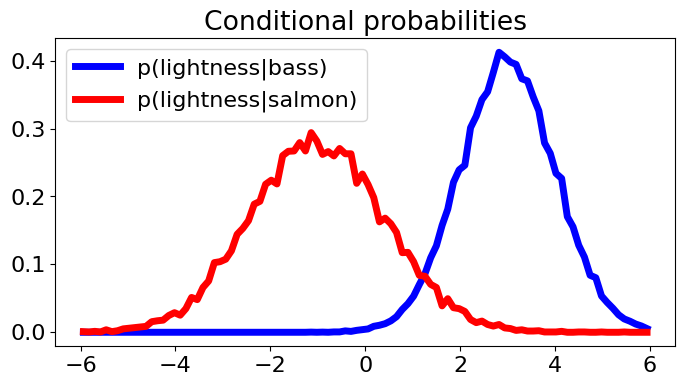

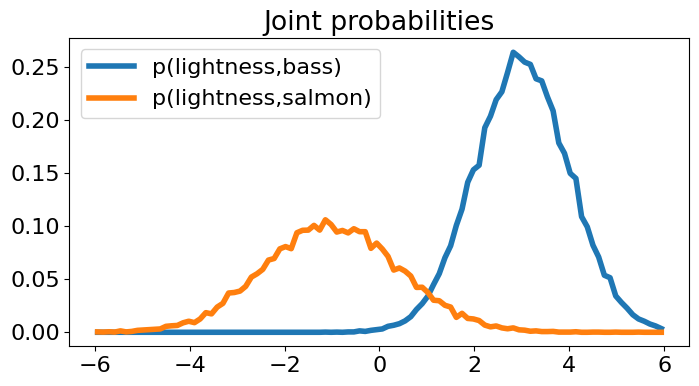

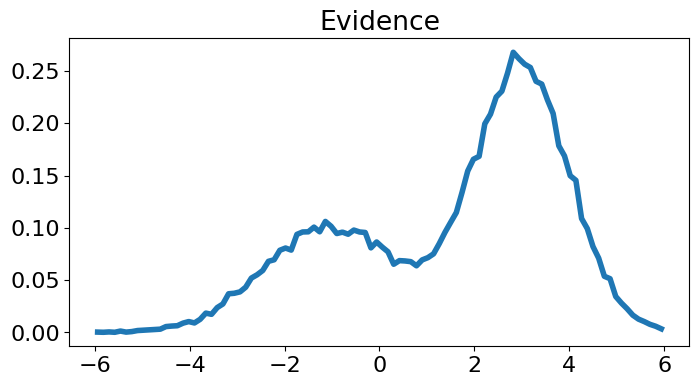

In [8]:
Nbins = 100
bins = np.linspace(-6,6,Nbins+1)
bincenters = (bins[0:Nbins]+bins[1:Nbins+1])/2


# Conditional probabilities
p_l_given_salmon,bc = np.histogram(salmonlightness, bins=bins,density=True)
p_l_given_bass,bc = np.histogram(basslightness, bins=bins,density=True)


# Priors
pbass = basscount/(basscount+salmoncount)
psalmon = salmoncount/(basscount+salmoncount)

fig = plt.figure()
s=plt.plot(bincenters,p_l_given_bass,'b',label='p(lightness|bass)',linewidth=5)
s=plt.plot(bincenters,p_l_given_salmon,'r',label='p(lightness|salmon)',linewidth=5)
s= fig.gca().legend()
s = plt.title('Conditional probabilities')


# To do: Compute joint probabilities and evidence
# Joint probabilities
p_l_and_bass = p_l_given_bass * pbass
p_l_and_salmon = p_l_given_salmon * psalmon

# Evidence
p_lightness = p_l_and_bass + p_l_and_salmon

fig = plt.figure()
s=plt.plot(bincenters,p_l_and_bass,label='p(lightness,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,label='p(lightness,salmon)',linewidth=4)
p_lightness = p_l_and_bass + p_l_and_salmon
s = plt.title('Joint probabilities')
s= fig.gca().legend()

fig = plt.figure()
s=plt.plot(bincenters,p_lightness,label='p(lightness)',linewidth=4)
s = plt.title('Evidence')


# Posterior probabilities and classification

The posterior probabilities can be evaluated using Bayes rule as

$$p({\rm bass|lightness}) = \frac{p({\rm lightness|bass})p({\rm bass})}{p({\rm lightness})}$$

We will add a small term in the denominator to avoid division by zero.

The bass and salmon regions correspond to 

$$ \mbox{    if    } p(\rm bass|lightness) > p(\rm salmon|lightness):  {\rm lightness} \rightarrow {\rm bass}$$
$$\mbox{    if    } p(\rm salmon|lightness) > p(\rm bass|lightness): {\rm lightness} \rightarrow {\rm salmon}$$

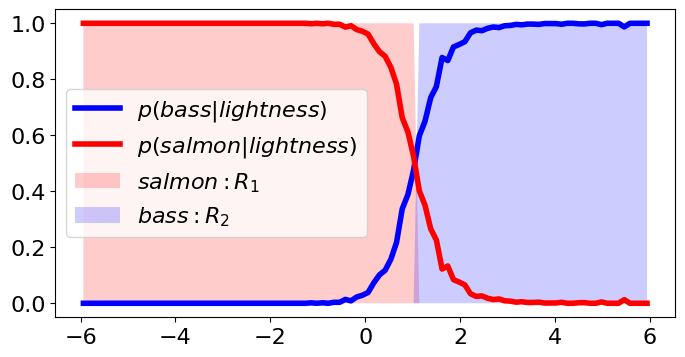

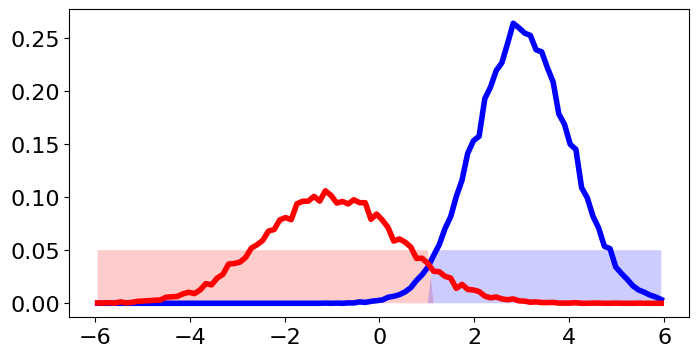

In [9]:
# Add a small constant to avoid division by zero
p_lightness = p_lightness + 1e-8*(p_lightness==0)

# To do: compute posterior probabilities
# change the lines below

p_bass_given_l = p_l_and_bass / p_lightness
p_salmon_given_l = p_l_and_salmon / p_lightness

fig = plt.figure()
s=plt.plot(bincenters,p_bass_given_l,'b',label='$p(bass|lightness)$',linewidth=4)
s=plt.plot(bincenters,p_salmon_given_l,'r',label='$p(salmon|lightness)$',linewidth=4)

bass_region = p_bass_given_l > p_salmon_given_l
salmon_region = p_bass_given_l <= p_salmon_given_l

s=plt.fill_between(bincenters,salmon_region,label='$salmon: R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass: R_2$',facecolor='blue', alpha=0.2)

s= fig.gca().legend(loc='best')

fig = plt.figure()
s=plt.plot(bincenters,p_l_and_bass,'b',label='p(lightness,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,'r',label='p(lightness,salmon)',linewidth=4)

bass_region = 0.05*(p_l_and_bass > p_l_and_salmon)
salmon_region = 0.05*(p_l_and_bass <= p_l_and_salmon)

s=plt.fill_between(bincenters,salmon_region,label='$salmon: R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass: R_2$',facecolor='blue', alpha=0.2)



# Comparing posterior probabilities is equivalent to comparing joint probabilites

The bass region correspond to 

$$ \mbox{    if    } p(\rm bass|lightness) > p(\rm salmon|lightness):  {\rm lightness} \rightarrow {\rm bass}$$

By comparing the expressions for the posteriors, we can also obtain

$$ \mbox{    if    } p(\rm bass,lightness) > p(salmon,lightness):  {\rm lightness} \rightarrow {\rm bass}$$


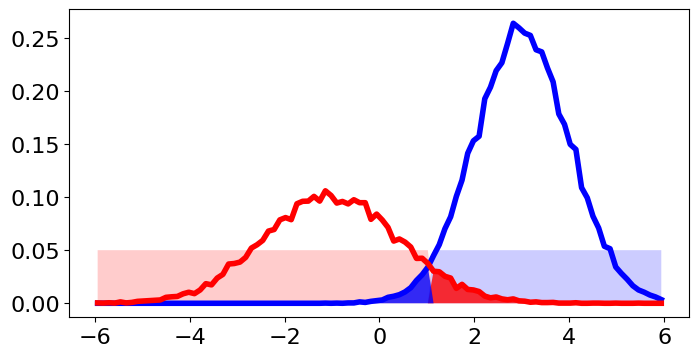

In [10]:
fig = plt.figure()
s=plt.plot(bincenters,p_l_and_bass,'b',label='p(lightness,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,'r',label='p(lightness,salmon)',linewidth=4)

s=plt.fill_between(bincenters,salmon_region,label='$salmon:  R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass:  R_2 $',facecolor='blue', alpha=0.2)

bass_region = (p_l_and_bass > p_l_and_salmon)
salmon_region = (p_l_and_bass <= p_l_and_salmon)

salmon_err = p_l_and_salmon*bass_region
bass_err = p_l_and_bass*salmon_region

s=plt.fill_between(bincenters,salmon_err,0*salmon_err,label='Error:salmon',facecolor='red', alpha=0.8)
s=plt.fill_between(bincenters,bass_err,0*bass_err,label='Error:bass',facecolor='blue', alpha=0.8)



## <font color=red>To do: Repeat for height/length </font>

32304
18203


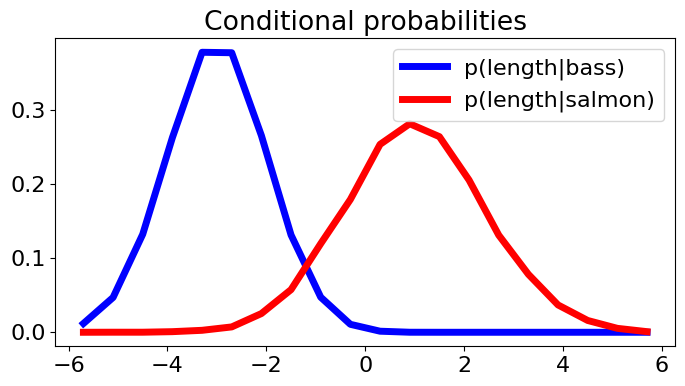

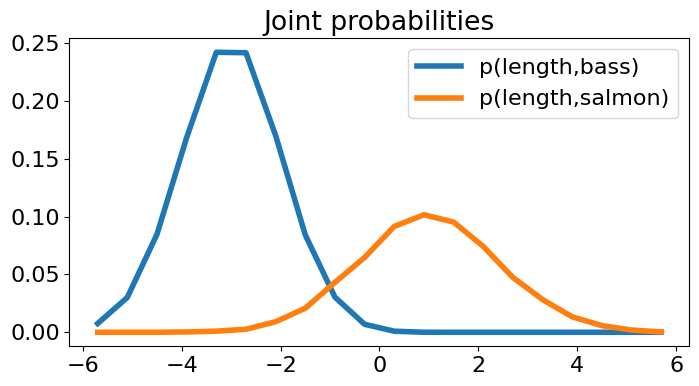

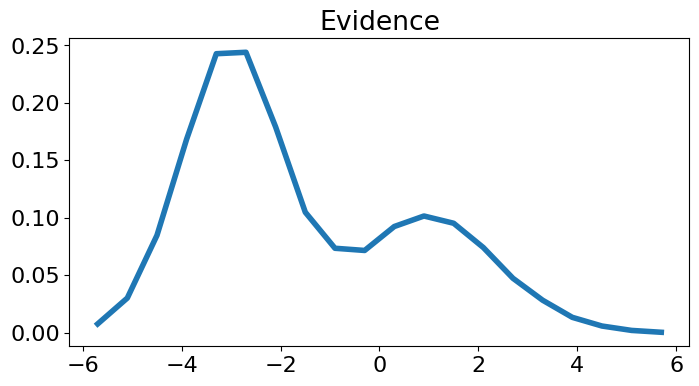

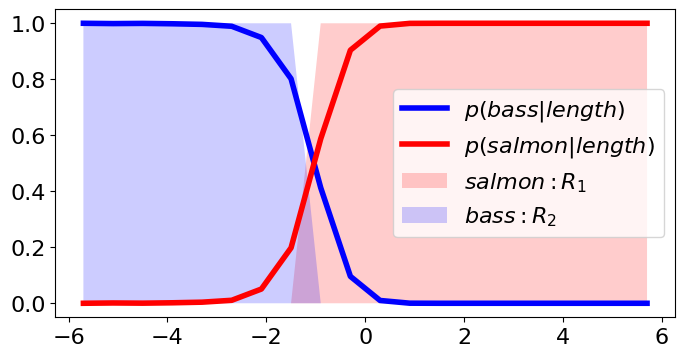

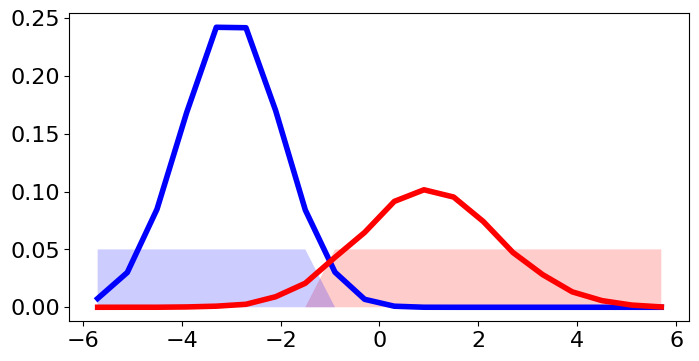

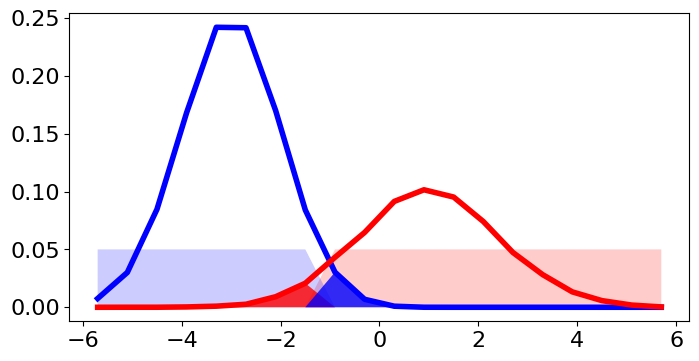

In [12]:
Nbins = 20
bins = np.linspace(-6,6,Nbins+1)
bincenters = (bins[0:Nbins]+bins[1:Nbins+1])/2

# To do: add code to do the above for height
# Extracting the fields with Fishtype=1 (bass)
bass = data[data["Fishtype"] == 1]
basslightness = bass['lightness'].to_numpy()
basslength = bass['length'].to_numpy()
basscount = bass['lightness'].count()

# Extracting the fields with Fishtype=0 (salmon)
salmon = data[data["Fishtype"] == 0]
salmonlightness = salmon['lightness'].to_numpy()
salmonlength = salmon['length'].to_numpy()
salmoncount = salmon['lightness'].count()

print(basscount)
print(salmoncount)

#----------------------------------------------------------------------------------------------------------------

# Nbins = 100
# bins = np.linspace(-6,6,Nbins+1)
# bincenters = (bins[0:Nbins]+bins[1:Nbins+1])/2

# Conditional probabilities
p_l_given_salmon,bc = np.histogram(salmonlength, bins=bins,density=True)
p_l_given_bass,bc = np.histogram(basslength, bins=bins,density=True)


# Priors
pbass = basscount/(basscount+salmoncount)
psalmon = salmoncount/(basscount+salmoncount)

fig = plt.figure()
s=plt.plot(bincenters,p_l_given_bass,'b',label='p(length|bass)',linewidth=5)
s=plt.plot(bincenters,p_l_given_salmon,'r',label='p(length|salmon)',linewidth=5)
s= fig.gca().legend()
s = plt.title('Conditional probabilities')


# To do: Compute joint probabilities and evidence
# Joint probabilities
p_l_and_bass = p_l_given_bass * pbass
p_l_and_salmon = p_l_given_salmon * psalmon

# Evidence
p_lightness = p_l_and_bass + p_l_and_salmon

fig = plt.figure()
s=plt.plot(bincenters,p_l_and_bass,label='p(length,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,label='p(length,salmon)',linewidth=4)
p_lightness = p_l_and_bass + p_l_and_salmon
s = plt.title('Joint probabilities')
s= fig.gca().legend()

fig = plt.figure()
s=plt.plot(bincenters,p_lightness,label='p(length)',linewidth=4)
s = plt.title('Evidence')

#----------------------------------------------------------------------------------------------------------------
# Add a small constant to avoid division by zero
p_lightness = p_lightness + 1e-8*(p_lightness==0)

# To do: compute posterior probabilities
# change the lines below

p_bass_given_l = p_l_and_bass / p_lightness
p_salmon_given_l = p_l_and_salmon / p_lightness

fig = plt.figure()
s=plt.plot(bincenters,p_bass_given_l,'b',label='$p(bass|length)$',linewidth=4)
s=plt.plot(bincenters,p_salmon_given_l,'r',label='$p(salmon|length)$',linewidth=4)

bass_region = p_bass_given_l > p_salmon_given_l
salmon_region = p_bass_given_l <= p_salmon_given_l

s=plt.fill_between(bincenters,salmon_region,label='$salmon: R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass: R_2$',facecolor='blue', alpha=0.2)

s= fig.gca().legend(loc='best')

fig = plt.figure()
s=plt.plot(bincenters,p_l_and_bass,'b',label='p(length,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,'r',label='p(length,salmon)',linewidth=4)

bass_region = 0.05*(p_l_and_bass > p_l_and_salmon)
salmon_region = 0.05*(p_l_and_bass <= p_l_and_salmon)

s=plt.fill_between(bincenters,salmon_region,label='$salmon: R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass: R_2$',facecolor='blue', alpha=0.2)
#----------------------------------------------------------------------------------------------------------------
fig = plt.figure()
s=plt.plot(bincenters,p_l_and_bass,'b',label='p(length,bass) ',linewidth=4)
s=plt.plot(bincenters,p_l_and_salmon,'r',label='p(length,salmon)',linewidth=4)

s=plt.fill_between(bincenters,salmon_region,label='$salmon:  R_1$',facecolor='red', alpha=0.2)
s=plt.fill_between(bincenters,bass_region,label='$bass:  R_2 $',facecolor='blue', alpha=0.2)

bass_region = (p_l_and_bass > p_l_and_salmon)
salmon_region = (p_l_and_bass <= p_l_and_salmon)

salmon_err = p_l_and_salmon*bass_region
bass_err = p_l_and_bass*salmon_region

s=plt.fill_between(bincenters,salmon_err,0*salmon_err,label='Error:salmon',facecolor='red', alpha=0.8)
s=plt.fill_between(bincenters,bass_err,0*bass_err,label='Error:bass',facecolor='blue', alpha=0.8)




